## **Tải dữ liệu**

In [1]:
# !gdown 1ezkXHiA8upwUlEM6EiQGj4VQJEvsUNLI
# !unzip /content/ASL_alphabet.zip -d /content/dataset

## **Nhập các thư viện cần thiết**

In [2]:
import cv2
from glob import glob
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Loading inception v3 network for transfer learning
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split


# **2. Chuẩn bị và tiền xử lý dữ liệu**

## **Config**

In [57]:
TRAINING_DIR = './data/ASL_alphabet/asl_alphabet_train/asl_alphabet_train/'
TEST_DIR = './data/ASL_alphabet/asl_alphabet_test/asl_alphabet_test/'
CLASSES = [folder[len(TRAINING_DIR):] for folder in glob(TRAINING_DIR + '/*')]
CLASSES.sort()

IMAGE_SIZE = 200
BATCH_SIZE = 64
N_CLASSES = 29
TRAIN_SIZE = 0.8
VALIDATION_SIZE = 0.1
TEST_SIZE = 0.1
MODEL_PATH = './model/cnn_asl_model.h5'

## **Data visualize**

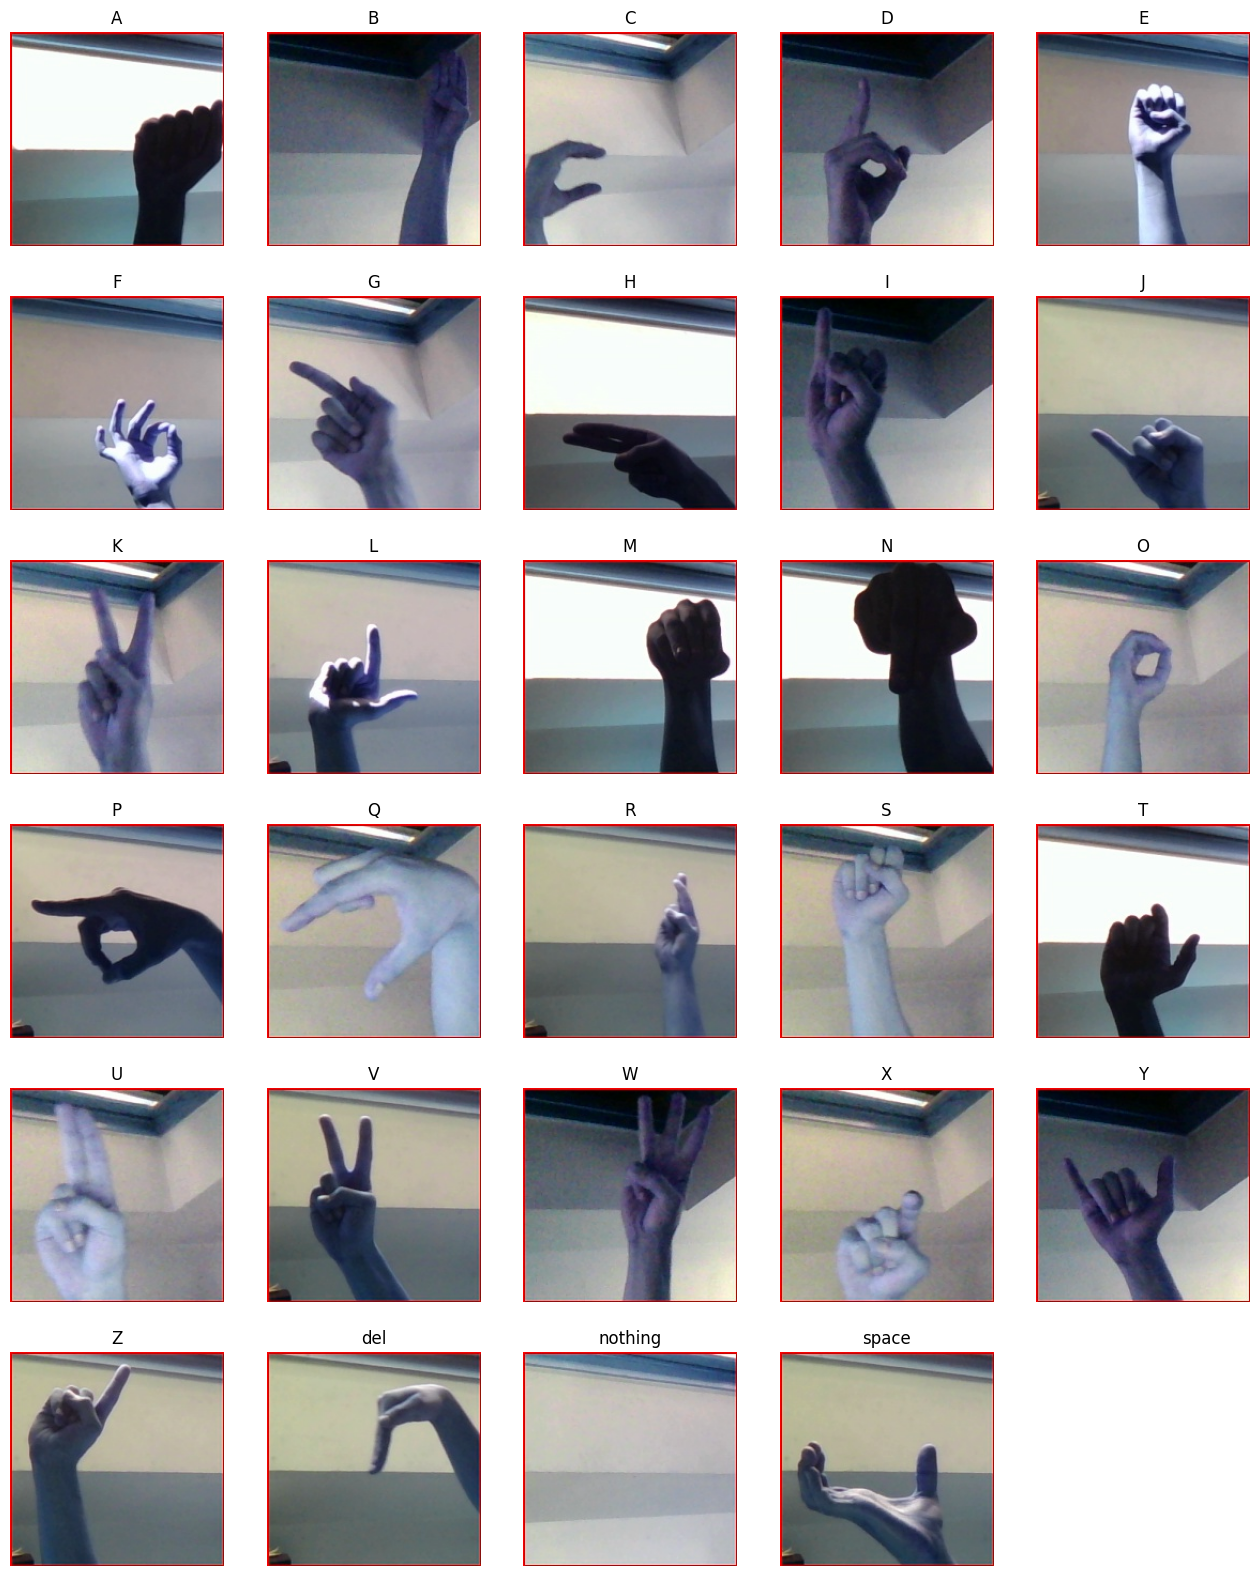

In [58]:
%matplotlib inline

def plot_one_sample_of_each(base_path):
    cols = 5
    rows = int(np.ceil(len(CLASSES) / cols))
    fig = plt.figure(figsize=(16, 20))

    for i in range(len(CLASSES)):
        cls = CLASSES[i]
        img_path = base_path + '/' + cls + '/**'
        path_contents = glob(img_path)

        imgs = random.sample(path_contents, 1)

        sp = plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.imread(imgs[0]))
        plt.title(cls)
        sp.axis('off')

    plt.show()

plot_one_sample_of_each(TRAINING_DIR)


## **Tiền xử lý dữ liệu**

In [59]:
# Tạo Metadata lưu giữ thông tin về image_path và label
list_path = []
list_labels = []
for label in CLASSES:
    label_path = os.path.join(TRAINING_DIR, label, "*")
    image_files = glob(label_path)

    sign_label = [label] * len(image_files)

    list_path.extend(image_files)
    list_labels.extend(sign_label)

metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

metadata

,image_path,label
0,./data/ASL_alphabet/asl_alphabet_train/asl_alp...,A
1,./data/ASL_alphabet/asl_alphabet_train/asl_alp...,A
2,./data/ASL_alphabet/asl_alphabet_train/asl_alp...,A
3,./data/ASL_alphabet/asl_alphabet_train/asl_alp...,A
4,./data/ASL_alphabet/asl_alphabet_train/asl_alp...,A
...,...,...
86995,./data/ASL_alphabet/asl_alphabet_train/asl_alp...,space
86996,./data/ASL_alphabet/asl_alphabet_train/asl_alp...,space
86997,./data/ASL_alphabet/asl_alphabet_train/asl_alp...,space
86998,./data/ASL_alphabet/asl_alphabet_train/asl_alp...,space


In [60]:
# Tách thành 3 tập train, validation, test theo tỉ lệ như config

X_train, X_test, y_train, y_test = train_test_split(
    metadata["image_path"], metadata["label"],
    test_size=TEST_SIZE,
    random_state=2023,
    shuffle=True,
    stratify=metadata["label"]
)

data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    data_train["image_path"], data_train["label"],
    test_size=VALIDATION_SIZE/TRAIN_SIZE,
    random_state=2023,
    shuffle=True,
    stratify=data_train["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
data_test = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

In [61]:
datagen = ImageDataGenerator(rescale=1/255.,)

train_gen = ImageDataGenerator(
    rescale=1/255.,
    brightness_range=[0.8,1.2],
    zoom_range=[1.0,1.2],
    horizontal_flip=True)

train_generator = train_gen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=BATCH_SIZE,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
    )

validation_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=BATCH_SIZE,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
    )

test_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=1,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        shuffle=False
)

Found 68512 validated image filenames belonging to 29 classes.
Found 9788 validated image filenames belonging to 29 classes.
Found 9788 validated image filenames belonging to 29 classes.


# **3. Xây dựng mô hình**


## **Transfer learning using Inception V3 Network**

In [62]:
base_model = InceptionV3(
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top = False,
    weights = 'imagenet'
)

for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(29, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## **Huấn luyện mô hình**

**Looking at the final model:**

In [63]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 99, 99, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 99, 99, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                            

**Setting up a callback funtion in order to stop training at a particular threshold:**

**Fit model :**

In [64]:
import scipy

# or import specific modules
from scipy import stats, linalg

In [65]:
train_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
)

Epoch 1/10


KeyboardInterrupt: 

## **Fine-Tuning**

In [ ]:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 99, 99, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 99, 99, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

 activation_2 (Activation)      (None, 97, 97, 64)   0           ['batch_normalization_2[0][0]']  
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 48, 64)   0           ['activation_2[0][0]']           
                                                                                                  
 conv2d_3 (Conv2D)              (None, 48, 48, 80)   5120        ['max_pooling2d[0][0]']          
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 48, 48, 80)  240         ['conv2d_3[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_3 (Activation)      (None, 48, 48, 80)   0           ['batch_normalization_3[0][0]']  
          

In [ ]:
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    # callbacks=[callback]
)

Epoch 1/5
1071/1071 [==============================] - 10578s 10s/step - loss: 0.1582 - accuracy: 0.9491 - val_loss: 0.1720 - val_accuracy: 0.9433
Epoch 2/5
1071/1071 [==============================] - 6805s 6s/step - loss: 0.0590 - accuracy: 0.9811 - val_loss: 0.1067 - val_accuracy: 0.9631
Epoch 3/5
1071/1071 [==============================] - 6177s 6s/step - loss: 0.0376 - accuracy: 0.9878 - val_loss: 0.0834 - val_accuracy: 0.9715
Epoch 4/5
1071/1071 [==============================] - 6218s 6s/step - loss: 0.0292 - accuracy: 0.9910 - val_loss: 0.0668 - val_accuracy: 0.9772
Epoch 5/5
1071/1071 [==============================] - 6148s 6s/step - loss: 0.0240 - accuracy: 0.9928 - val_loss: 0.0577 - val_accuracy: 0.9809


## **Lưu mô hình**

**As we were satisfied with our results we save our model:**

In [83]:
model.endswith(fine_tune_history)

AttributeError: 'Functional' object has no attribute 'endswith'

In [76]:
MODEL_PATH1 = './model/fine_tune_asl_model.h5'
model.save(MODEL_PATH1)

AttributeError: 'History' object has no attribute 'save'

In [ ]:
# Saving the model
model.save(MODEL_PATH)

# **4. Đánh giá mô hình**

## **Model Testing**

In [ ]:
from sklearn.metrics import accuracy_score

In [79]:
predictions = model.predict(test_generator)
predictions = predictions.argmax(axis=1)
true_labels = test_generator.classes

accuracy = accuracy_score(predictions, true_labels)
print("%s: %.2f%%" % ("Evaluate Test Accuracy", accuracy))

9788/9788 [==============================] - 812s 83ms/step
Evaluate Test Accuracy: 0.07%


## **Training Loss and Metrics**

In [71]:
def visualize_train_val(history):
  # Visualize Training and Validation Results
  fig = make_subplots(
          rows=1, cols=2,
          subplot_titles=["Model Loss", "Model Accuracy"],
  )

  # Configuration Plot
  class PlotCFG:
      marker_size = 8
      line_size = 2
      train_color = "#76503d"
      valid_color = "#deb392"


  # Loss Plot
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  fig.add_trace(
      go.Scatter(
          x=np.arange(1, len(loss)+1), y=loss,
          mode="markers+lines",
          marker=dict(
              color=PlotCFG.train_color, size=PlotCFG.marker_size,
              line=dict(color="White", width=0.5)
          ),
          line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
          name="Training Loss"
      ), row=1, col=1
  )

  fig.add_trace(
      go.Scatter(
          x=np.arange(1, len(val_loss)+1), y=val_loss,
          mode="markers+lines",
          marker=dict(
              color=PlotCFG.valid_color, size=PlotCFG.marker_size,
              line=dict(color="White", width=0.5)
          ),
          line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
          name="Validation Loss"
      ), row=1, col=1
  )



  # Accuracy Plot
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  fig.add_trace(
      go.Scatter(
          x=np.arange(1, len(acc)+1), y=acc,
          mode="markers+lines",
          marker=dict(
              color=PlotCFG.train_color, size=PlotCFG.marker_size,
              line=dict(color="White", width=0.5)
          ),
          line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
          name="Training Accuracy"
      ), row=1, col=2
  )
  fig.add_trace(
      go.Scatter(
          x=np.arange(1, len(val_acc)+1), y=val_acc,
          mode="markers+lines",
          marker=dict(
              color=PlotCFG.valid_color, size=PlotCFG.marker_size,
              line=dict(color="White", width=0.5)
          ),
          line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
          name="Validation Accuracy"
      ), row=1, col=2
  )

  # Update Axes
  fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=1)
  fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=2)
  fig.update_yaxes(title="Categorical Loss", linecolor="Black", ticks="outside", row=1, col=1)
  fig.update_yaxes(title="Accuracy", linecolor="Black", ticks="outside", row=1, col=2)


  # Update Layout
  fig.update_layout(
      title="Training Loss and Metrics", title_x=0.5,
      width=950, height=400,
      showlegend=False,
      plot_bgcolor="White",
      paper_bgcolor="White"
  )

  # Show
  fig.show(iframe_connected=True)


In [81]:
visualize_train_val(fine_tune_history)

In [ ]:
visualize_train_val(train_history)

### Fine-tune

## **Confusion Matrix**

In [73]:
confusion_matrix = tf.math.confusion_matrix(
        labels=true_labels,
        predictions=predictions,
        num_classes=29)

In [74]:
# Create Figure
fig = go.Figure()

# Heatmap
fig.add_trace(
    go.Heatmap(
        z=confusion_matrix,
        x=CLASSES,
        y=CLASSES,
        text=confusion_matrix,
        texttemplate="<b>%{text}</b>",
        textfont={"size":8},
        colorscale=[[0, '#f4f4f4'],[1.0, '#76503d']],
        showscale = False,
        ygap = 5,
        xgap = 5,
        hovertemplate=
        '''
        Actual: %{y}<br>
        Predicted: %{x}<br>
        Total: %{text}
        ''',
        name="Confusion Matrix"
    )
)

# Update Axes
fig.update_xaxes(title="<b>Predicted Values</b>", tickfont_size=10)
fig.update_yaxes(title="<b>Actual Values</b>", tickfont_size=10)

# Update Layout
fig.update_layout(title_text='Confusion Matrix', title_x=0.5, font_size=14,
                  width=1050,
                  height=1115,
                  plot_bgcolor='white',
                  showlegend=False,
)

# Show
fig.show()

## **Kiểm tra ảnh trên thực tế**

In [ ]:
# download self test, classes
!gdown 1cBKU4hs15XqA_Gheh9Acaxuie69nnnwy
!gdown 12ES0wAtwtEE8LOBq4KszOsnuseVyf6A_
!unzip /content/self_test.zip -d /content/

Downloading...
From: https://drive.google.com/uc?id=1cBKU4hs15XqA_Gheh9Acaxuie69nnnwy
To: f:\ActionDetectionforSignLanguage-main\American-Sign-Language-Recognition-main\self_test.zip

  0%|          | 0.00/10.9M [00:00<?, ?B/s]
  5%|▍         | 524k/10.9M [00:01<00:32, 325kB/s]
 10%|▉         | 1.05M/10.9M [00:02<00:21, 467kB/s]
 14%|█▍        | 1.57M/10.9M [00:03<00:21, 435kB/s]
 19%|█▉        | 2.10M/10.9M [00:04<00:19, 461kB/s]
 24%|██▍       | 2.62M/10.9M [00:05<00:17, 477kB/s]
 29%|██▉       | 3.15M/10.9M [00:07<00:18, 421kB/s]
 34%|███▎      | 3.67M/10.9M [00:08<00:15, 468kB/s]
 38%|███▊      | 4.19M/10.9M [00:10<00:18, 374kB/s]
 43%|████▎     | 4.72M/10.9M [00:13<00:23, 264kB/s]
 48%|████▊     | 5.24M/10.9M [00:16<00:25, 221kB/s]
 53%|█████▎    | 5.77M/10.9M [00:19<00:26, 198kB/s]
 58%|█████▊    | 6.29M/10.9M [00:22<00:23, 200kB/s]
 62%|██████▏   | 6.82M/10.9M [00:25<00:20, 197kB/s]
 67%|██████▋   | 7.34M/10.9M [00:26<00:15, 232kB/s]
 72%|███████▏  | 7.86M/10.9M [00:28<00:11, 25

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=12ES0wAtwtEE8LOBq4KszOsnuseVyf6A_ 

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
image_location = './self_test/A.png'

# Creating list of available classes stored in classes.txt.
classes_file = open("classes.txt")
classes_string = classes_file.readline()
classes = classes_string.split()
classes.sort()  # The predict function sends out output in sorted order.

IMAGE_SIZE = 200

img = cv2.imread(image_location)
img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
img = np.array(img) / 255.
plt.imshow(img)
img = img.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))

prediction = np.array(model.predict(img))
predicted = classes[prediction.argmax()]

print(predicted)

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'
